In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
train_data_path = join('/aiffel/aiffel/kaggle_kakr_housing/data', 'train.csv')
sub_data_path = join('/aiffel/aiffel/kaggle_kakr_housing/data', 'test.csv')

## 1. 데이터 살펴보기
pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴보겠습니다.
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [3]:
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


데이터 상관도를 한번 보겠습니다.

In [4]:
# data['sqft_ratio'] = data['sqft_living15']/data['sqft_lot15']   - 부지와 건물의 비율 가격과 별상관없음
# data['date'] = data['date'].apply(lambda x : str(x[:4])).astype(int)
data.corr()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,1.000000,0.020899,0.010520,0.104030,0.041725,-0.034077,0.182848,-0.011775,-0.024360,-0.101618,0.078622,0.073086,-0.050634,0.202477,-0.029810,-0.005761,0.002588,0.014757,0.029248,-0.032269
price,0.020899,1.000000,0.323672,0.525479,0.702899,0.096793,0.262588,0.265738,0.400806,0.039740,0.667211,0.608577,0.322218,0.047290,0.140808,-0.051498,0.301604,0.023547,0.586419,0.086384
bedrooms,0.010520,0.323672,1.000000,0.530548,0.596974,0.033475,0.189532,-0.004819,0.085703,0.034885,0.375286,0.494867,0.315183,0.158799,0.022729,-0.162081,-0.011190,0.135802,0.407394,0.027242
bathrooms,0.104030,0.525479,0.530548,1.000000,0.755853,0.089308,0.508649,0.075452,0.187488,-0.125907,0.666278,0.688255,0.282642,0.503964,0.065423,-0.207500,0.018110,0.227669,0.573541,0.088120
sqft_living,0.041725,0.702899,0.596974,0.755853,1.000000,0.176500,0.363193,0.108137,0.282821,-0.054213,0.762543,0.878736,0.434017,0.315927,0.064893,-0.200745,0.051609,0.245429,0.760271,0.184176
sqft_lot,-0.034077,0.096793,0.033475,0.089308,0.176500,1.000000,0.001535,0.025584,0.080441,-0.002099,0.119906,0.186242,0.017818,0.058686,-0.001451,-0.127709,-0.082234,0.227451,0.147562,0.728458
floors,0.182848,0.262588,0.189532,0.508649,0.363193,0.001535,1.000000,0.031159,0.034511,-0.261016,0.462598,0.529476,-0.239350,0.490436,0.009752,-0.059107,0.049004,0.126983,0.287125,-0.010287
waterfront,-0.011775,0.265738,-0.004819,0.075452,0.108137,0.025584,0.031159,1.000000,0.389669,0.011613,0.088061,0.081968,0.071576,-0.026523,0.104168,0.028632,-0.014772,-0.037922,0.091810,0.028255
view,-0.024360,0.400806,0.085703,0.187488,0.282821,0.080441,0.034511,0.389669,1.000000,0.045255,0.247924,0.172693,0.265880,-0.061670,0.107605,0.089247,0.005285,-0.073151,0.278267,0.076501
condition,-0.101618,0.039740,0.034885,-0.125907,-0.054213,-0.002099,-0.261016,0.011613,0.045255,1.000000,-0.143599,-0.152856,0.175064,-0.366590,-0.062342,0.001106,-0.015974,-0.110742,-0.091407,-0.003873


In [5]:
y = data['price']

del data['price']
# data['sqft_ratio'] = data['date'].apply(lambda x : str(x[:6])).astype(str)

In [6]:
train_len = len(data)
data = pd.concat((data, sub), axis=0)

In [7]:
data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


## 2. 간단한 전처리 
각 변수들에 대해 결측 유무를 확인하고, 분포를 확인해보면서 간단하게 전처리를 하겠습니다.
### 결측치 확인
먼저 데이터에 결측치가 있는지를 확인하겠습니다.<br>
missingno 라이브러리의 matrix 함수를 사용하면, 데이터의 결측 상태를 시각화를 통해 살펴볼 수 있습니다.

<AxesSubplot:>

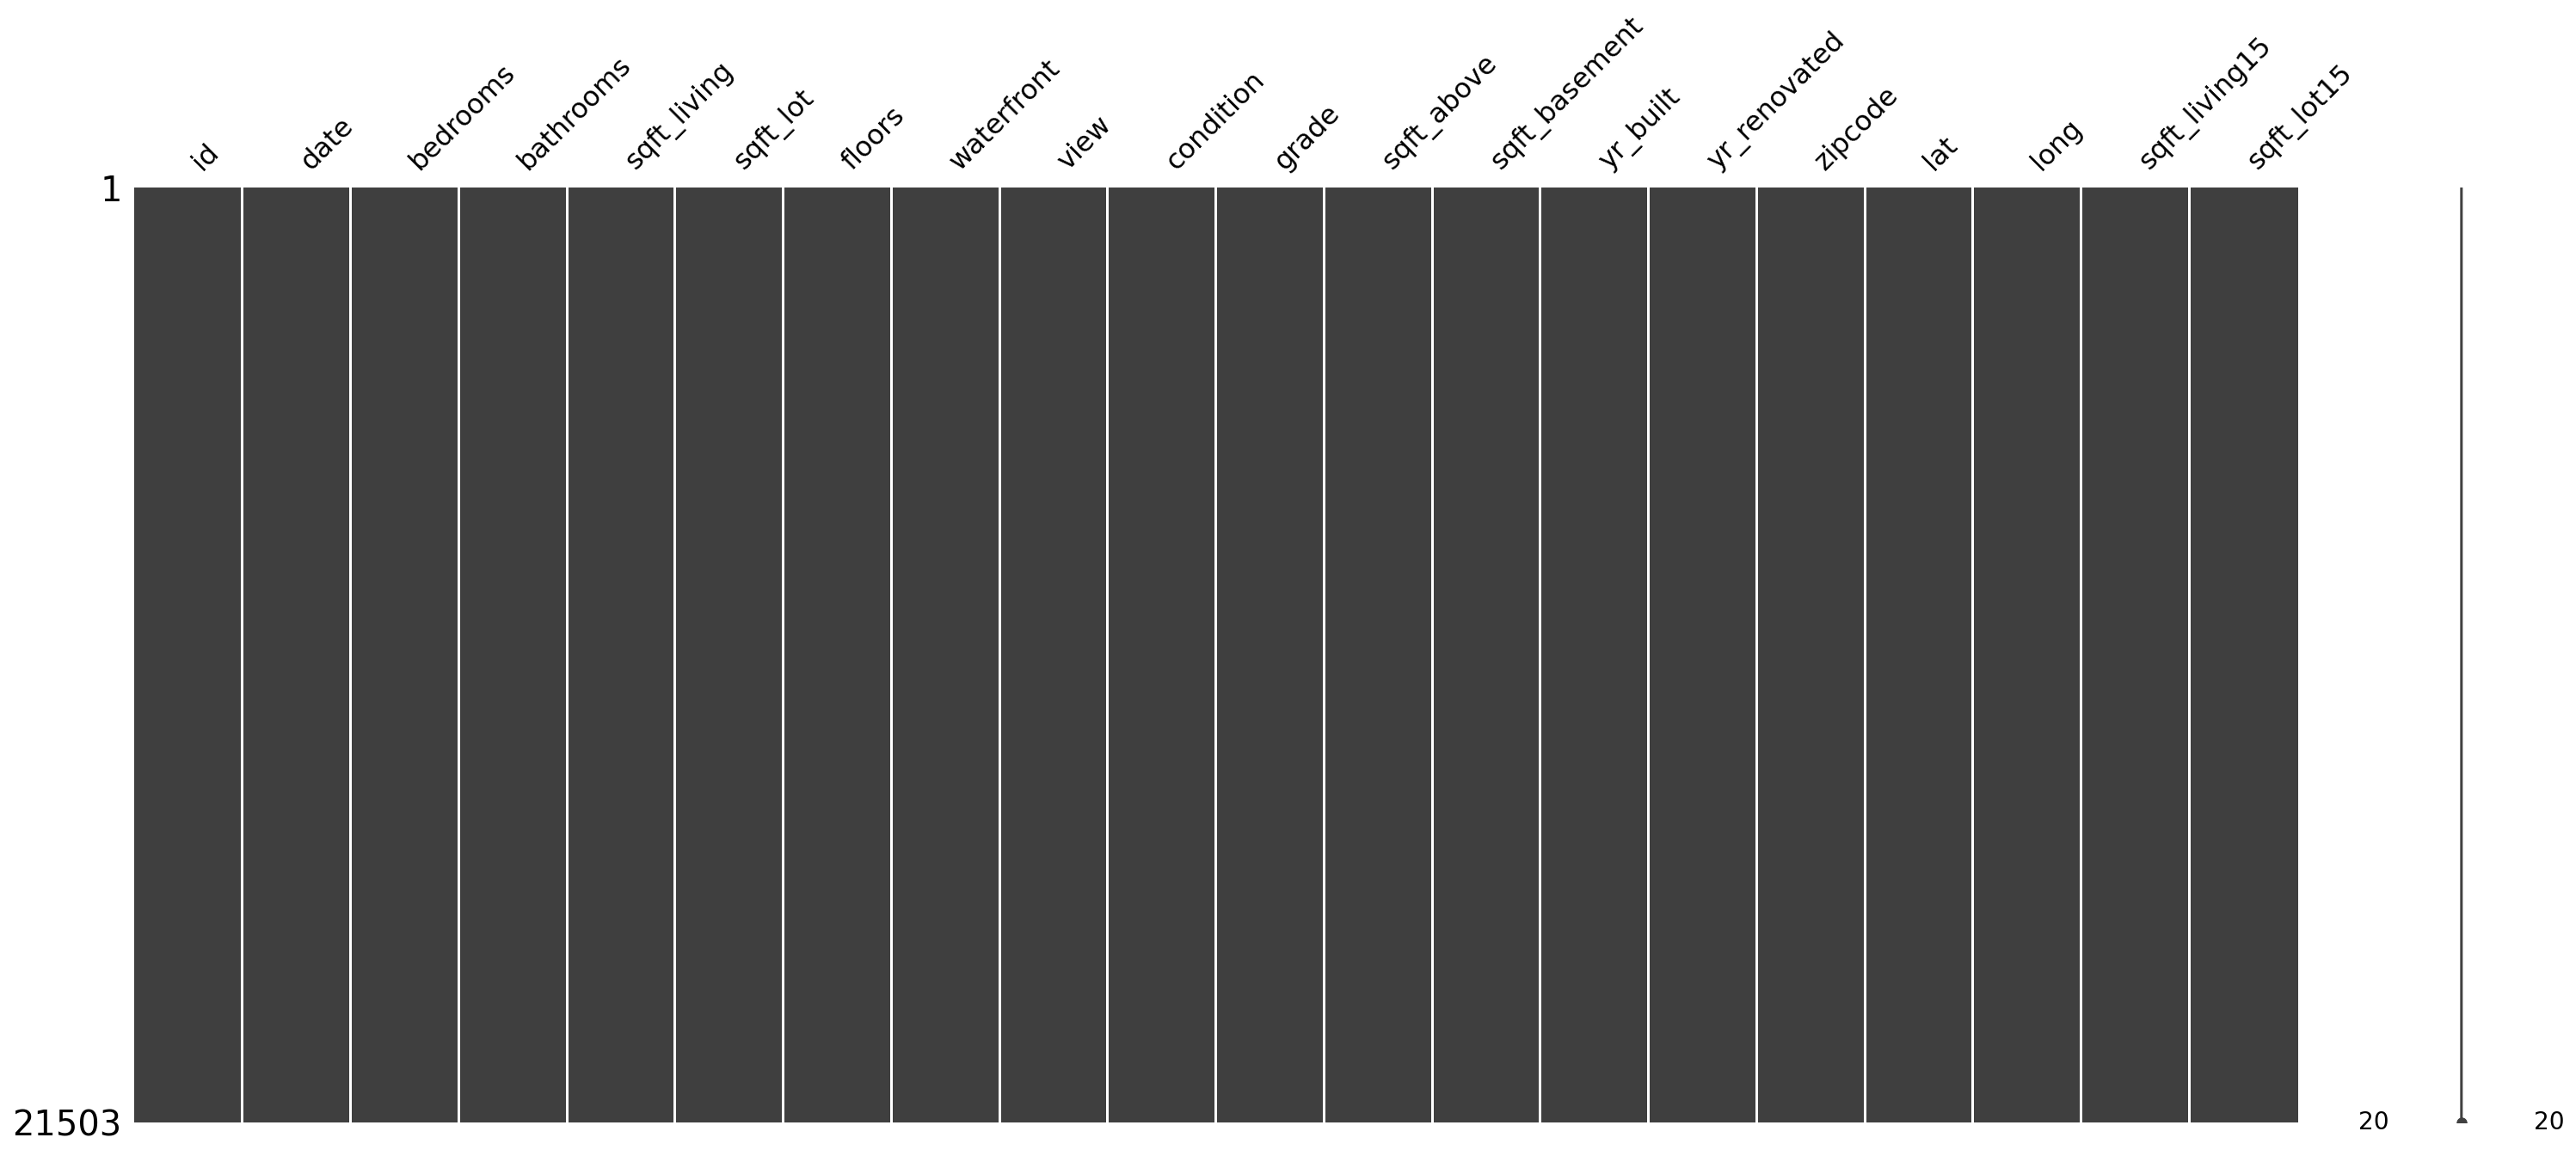

In [8]:
msno.matrix(data)

모든 변수에 결측치가 없는 것으로 보이지만, 혹시 모르니 확실하게 살펴보겠습니다.<br>

In [9]:
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


### id, date 변수 정리
id 변수는 모델이 집값을 예측하는데 도움을 주지 않으므로 제거합니다.<br>
date 변수는 연월일시간으로 값을 가지고 있는데, 연월만 고려하는 범주형 변수로 만들겠습니다.

In [10]:
sub_id = data['id'][train_len:]
del data['id']
# del data['long']#가격과 상관도가 낮은 long은 삭제하겠습니다.
# del data['yr_built']#가격과 상관도가 낮은 yr_built은 삭제하겠습니다.
# del data['sqft_lot15']#가격과 상관도가 낮은 sqft_lot15은 삭제하겠습니다.
# del data['date']#가격과 상관도가 낮은 date은 삭제하겠습니다.
data['date'] = data['date'].apply(lambda x : str(x[:6])).astype(int)

### 각 변수들의 분포 확인
한쪽으로 치우친 분포는 모델이 결과를 예측하기에 좋지 않은 영향을 미치므로 다듬어줄 필요가 있습니다.

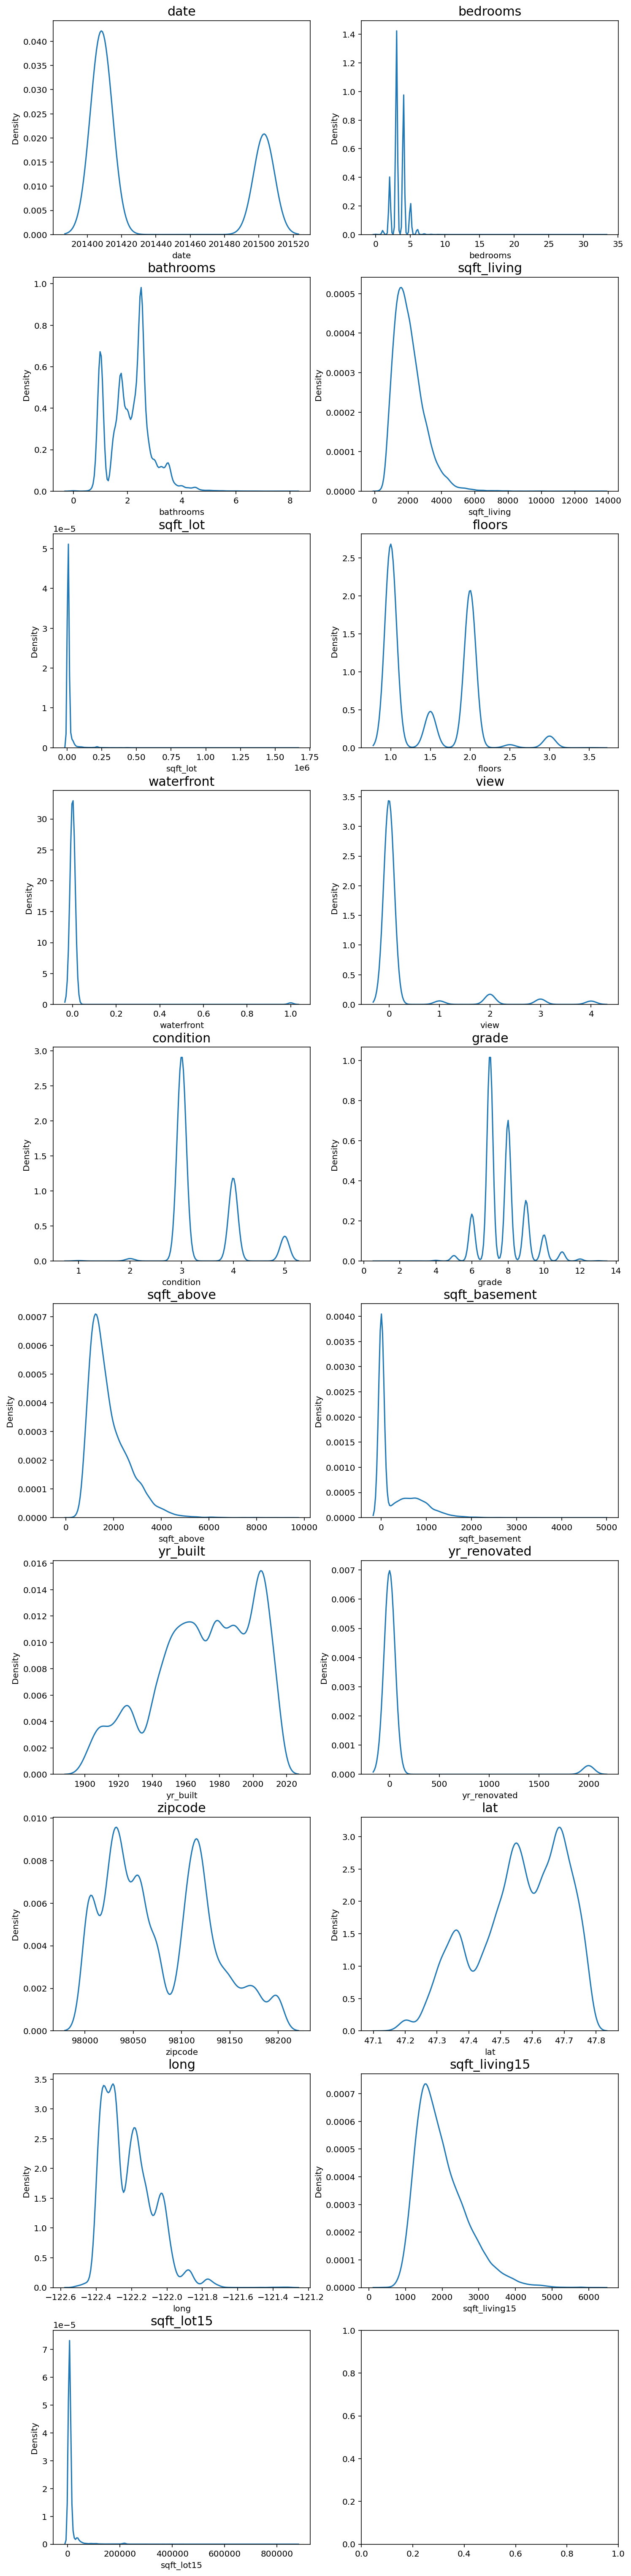

In [11]:
fig, ax = plt.subplots(len(data.columns)//2+len(data.columns)%2, 2, figsize=(12, 55))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 1
for c in data.columns:
    sns.kdeplot(data=data[c], ax=ax[(count-1)//2][(count+1)%2])
    ax[(count-1)//2][(count+1)%2].set_title(c, fontsize=15)
    count += 1
# columns = data.columns
# for row in range(9):
#     for col in range(2):
#         sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
#         ax[row][col].set_title(columns[count], fontsize=15)
#         count += 1
#         if count == 19 :
#             break

price, bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement 변수가 한쪽으로 치우친 경향을 보였습니다.<br>
log-scaling을 통해 데이터 분포를 정규분포에 가깝게 만들어 보겠습니다.

In [12]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

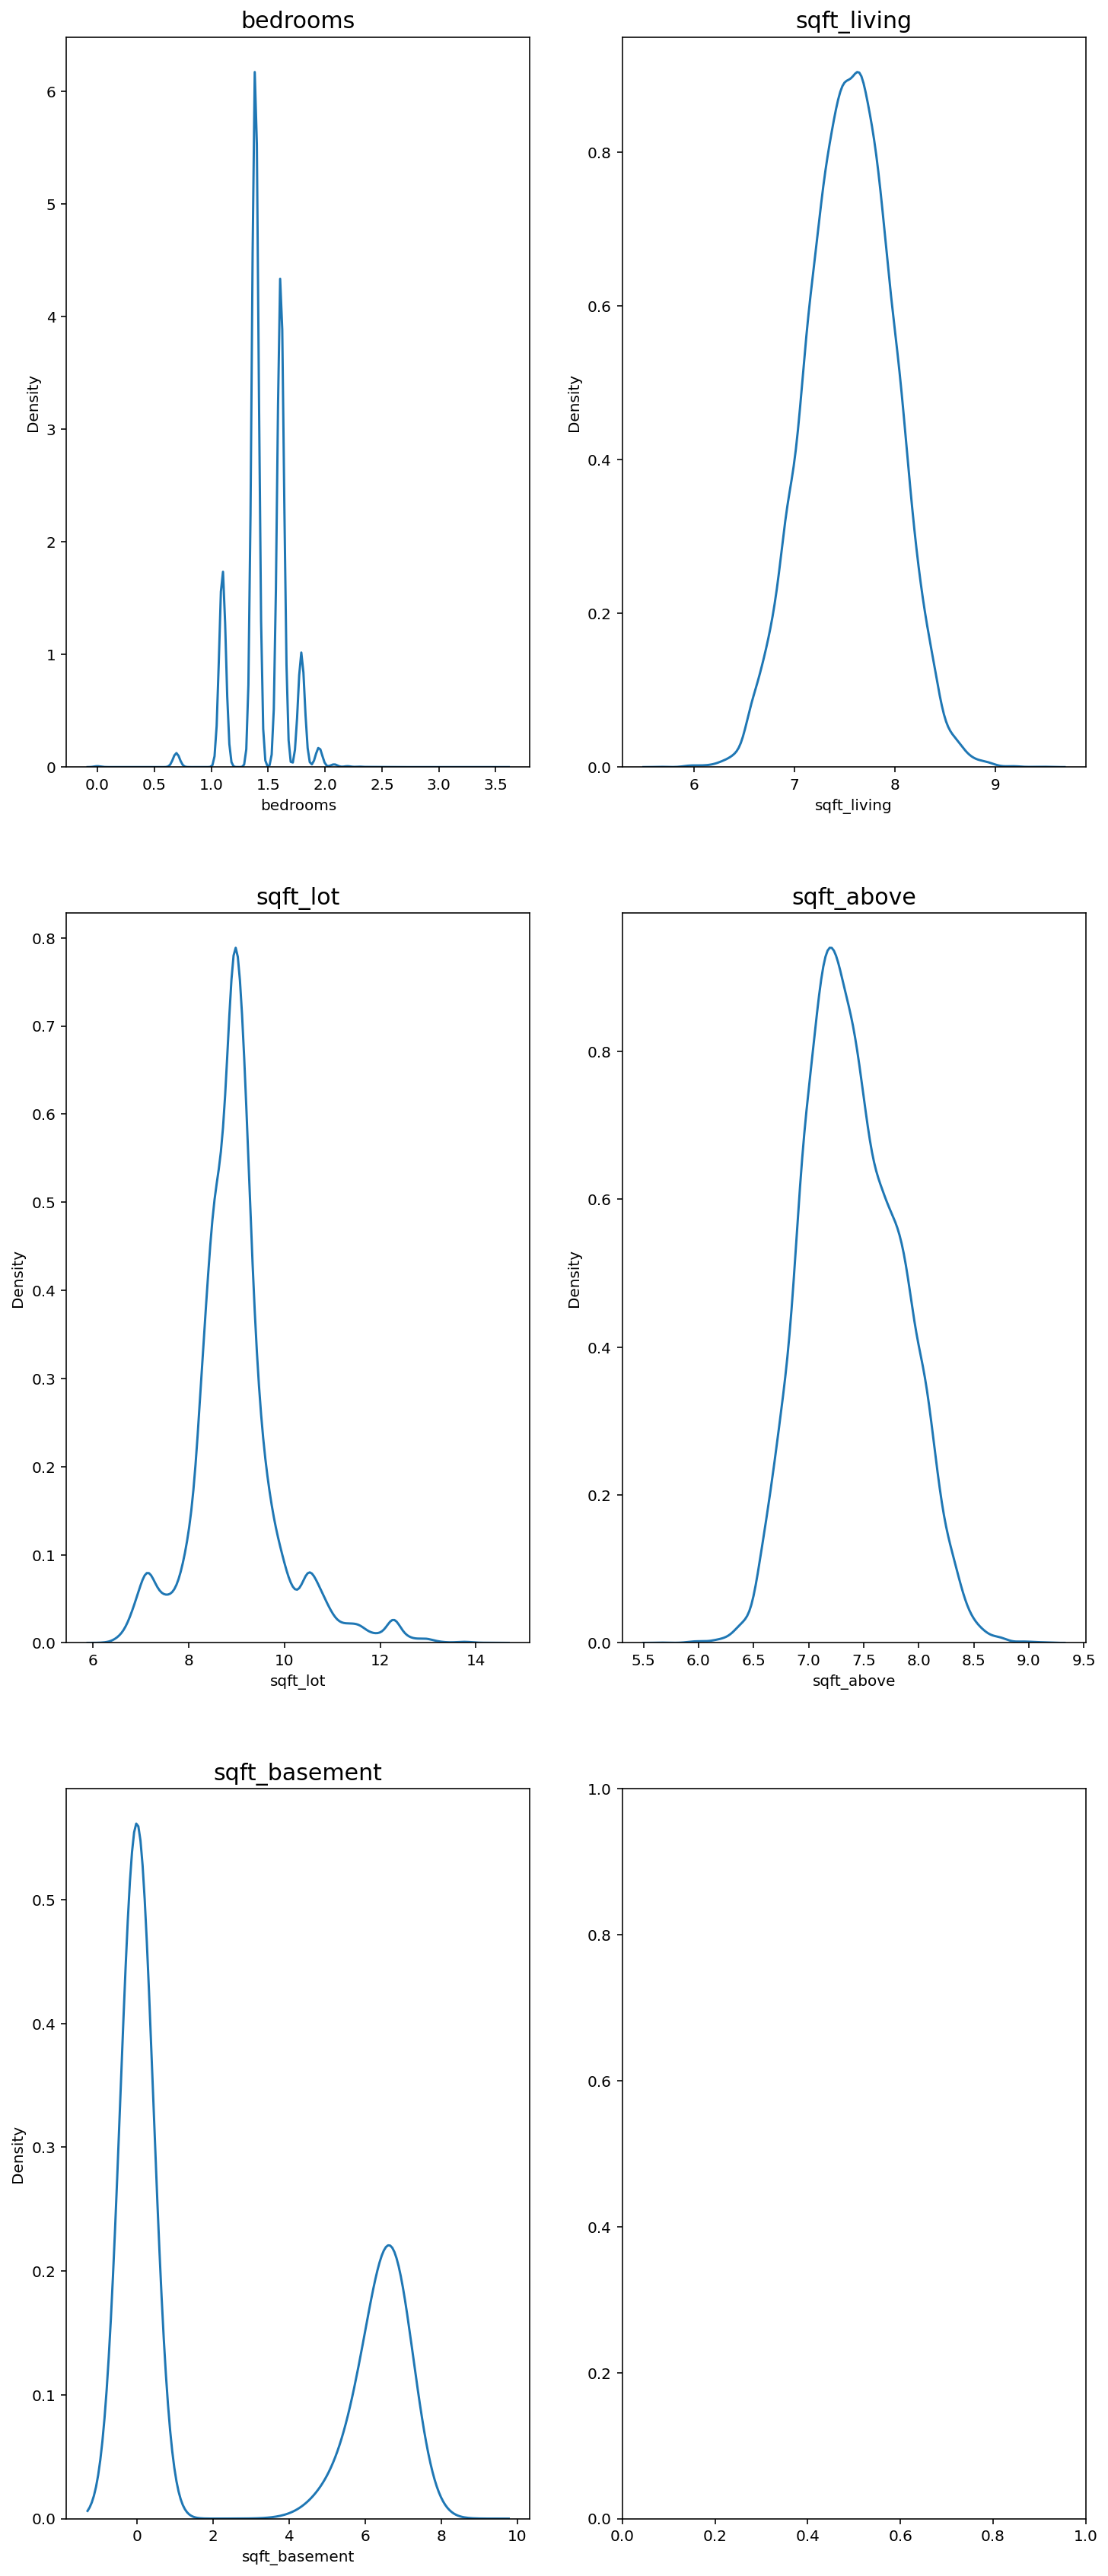

In [13]:
# fig, ax = plt.subplots(3, 2, figsize=(10, 15))

# count = 0
# for row in range(3):
#     for col in range(2):
#         if count == 5:
#             break
#         sns.kdeplot(data[skew_columns[count]], ax=ax[row][col])
#         ax[row][col].set_title(skew_columns[count], fontsize=15)
#         count+=1
fig, ax = plt.subplots(len(skew_columns)//2+len(skew_columns)%2, 2, figsize=(12, 30))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 

count = 1
for c in skew_columns:
    sns.kdeplot(data=data[c], ax=ax[(count-1)//2][(count+1)%2])
    ax[(count-1)//2][(count+1)%2].set_title(c, fontsize=15)
    count += 1


어느정도 치우침이 줄어든 분포를 확인할 수 있습니다.

In [14]:
sub = data.iloc[train_len:, :]
x = data.iloc[:train_len, :]

## 3. 모델링
### Average Blending
여러가지 모델의 결과를 산술 평균을 통해 Blending 모델을 만들겠습니다.

In [15]:
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)
# randomForestReg = RandomForestRegressor(random_state=2019)
models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

### Cross Validation
교차 검증을 통해 모델의 성능을 간단히 평가하겠습니다.

In [16]:
def get_cv_score(models):
    kfold = KFold(n_splits=5).get_n_splits(x.values)
    for m in models:
        print("Model {} CV score : {:.4f}".format(m['name'], np.mean(cross_val_score(m['model'], x.values, y)), 
                                             kf=kfold))

In [17]:
get_cv_score(models)

Model GradientBoosting CV score : 0.8597
Model XGBoost CV score : 0.8861
Model LightGBM CV score : 0.8819


In [18]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=1):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [19]:
param_grid = {}
param_grid['eta']=[0.05,0.1,0.01]
# param_grid['num_iterations'] =[100,1000,500,1500]
# param_grid['num_rounds'] =[100,1000,500,1500]
param_grid['max_depth']  =[3,5,7,10,15,20]
tt = my_GridSearch(xgboost,x.values, y,param_grid)

xgboost = xgb.XGBRegressor(random_state=2019,  \
                             eta = tt.iloc[0]['eta'],  \
#                              num_rounds = int(tt.iloc[0]['num_rounds']),  \
                             max_depth =  int(tt.iloc[0]['max_depth']))
print(tt)
print(tt.iloc[0]['eta'])
# print(tt.iloc[0]['num_rounds'])
print(tt.iloc[0]['max_depth'])

tt
models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END ..............................eta=0.05, max_depth=3; total time=   1.3s
[CV] END ..............................eta=0.05, max_depth=3; total time=   1.2s
[CV] END ..............................eta=0.05, max_depth=3; total time=   1.3s
[CV] END ..............................eta=0.05, max_depth=3; total time=   1.3s
[CV] END ..............................eta=0.05, max_depth=3; total time=   1.2s
[CV] END ..............................eta=0.05, max_depth=5; total time=   2.1s
[CV] END ..............................eta=0.05, max_depth=5; total time=   2.2s
[CV] END ..............................eta=0.05, max_depth=5; total time=   2.2s
[CV] END ..............................eta=0.05, max_depth=5; total time=   2.2s
[CV] END ..............................eta=0.05, max_depth=5; total time=   2.1s
[CV] END ..............................eta=0.05, max_depth=7; total time=   3.2s
[CV] END ..............................eta=0.05,

In [20]:
param_grid = {}
param_grid['learning_rate']=[0.05,0.1,0.01]
# param_grid['num_iterations'] =[100,1000,500,1500]
param_grid['n_estimators'] =[50,100,150,200,250,300,350,400]
param_grid['max_depth']  =[3,5,7,10,-1,15,20]
tt = my_GridSearch(lightgbm,x.values, y,param_grid)


lightgbm = lgb.LGBMRegressor(random_state=2019,  \
                             learning_rate = tt.iloc[0]['learning_rate'],  \
                             n_estimators = int(tt.iloc[0]['n_estimators']),  \
                             max_depth =  int(tt.iloc[0]['max_depth']))
print(tt)
print(tt.iloc[0]['learning_rate'])
print(tt.iloc[0]['n_estimators'])
print(tt.iloc[0]['max_depth'])

tt
models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

Fitting 5 folds for each of 168 candidates, totalling 840 fits
[CV] END ...learning_rate=0.05, max_depth=3, n_estimators=50; total time=   0.1s
[CV] END ...learning_rate=0.05, max_depth=3, n_estimators=50; total time=   0.1s
[CV] END ...learning_rate=0.05, max_depth=3, n_estimators=50; total time=   0.1s
[CV] END ...learning_rate=0.05, max_depth=3, n_estimators=50; total time=   0.1s
[CV] END ...learning_rate=0.05, max_depth=3, n_estimators=50; total time=   0.1s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time=   0.2s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time=   0.2s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time=   0.2s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time=   0.2s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time=   0.2s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=150; total time=   0.3s
[CV] END ..learning_rate=0.05, max_depth=3, n_

[CV] END ..learning_rate=0.05, max_depth=7, n_estimators=250; total time=   0.8s
[CV] END ..learning_rate=0.05, max_depth=7, n_estimators=250; total time=   0.8s
[CV] END ..learning_rate=0.05, max_depth=7, n_estimators=250; total time=   0.7s
[CV] END ..learning_rate=0.05, max_depth=7, n_estimators=250; total time=   0.8s
[CV] END ..learning_rate=0.05, max_depth=7, n_estimators=300; total time=   0.9s
[CV] END ..learning_rate=0.05, max_depth=7, n_estimators=300; total time=   1.0s
[CV] END ..learning_rate=0.05, max_depth=7, n_estimators=300; total time=   0.9s
[CV] END ..learning_rate=0.05, max_depth=7, n_estimators=300; total time=   0.9s
[CV] END ..learning_rate=0.05, max_depth=7, n_estimators=300; total time=   1.0s
[CV] END ..learning_rate=0.05, max_depth=7, n_estimators=350; total time=   1.1s
[CV] END ..learning_rate=0.05, max_depth=7, n_estimators=350; total time=   1.1s
[CV] END ..learning_rate=0.05, max_depth=7, n_estimators=350; total time=   1.0s
[CV] END ..learning_rate=0.0

[CV] END ..learning_rate=0.05, max_depth=15, n_estimators=50; total time=   0.2s
[CV] END ..learning_rate=0.05, max_depth=15, n_estimators=50; total time=   0.3s
[CV] END .learning_rate=0.05, max_depth=15, n_estimators=100; total time=   0.4s
[CV] END .learning_rate=0.05, max_depth=15, n_estimators=100; total time=   0.5s
[CV] END .learning_rate=0.05, max_depth=15, n_estimators=100; total time=   0.4s
[CV] END .learning_rate=0.05, max_depth=15, n_estimators=100; total time=   0.5s
[CV] END .learning_rate=0.05, max_depth=15, n_estimators=100; total time=   0.5s
[CV] END .learning_rate=0.05, max_depth=15, n_estimators=150; total time=   0.7s
[CV] END .learning_rate=0.05, max_depth=15, n_estimators=150; total time=   0.7s
[CV] END .learning_rate=0.05, max_depth=15, n_estimators=150; total time=   0.6s
[CV] END .learning_rate=0.05, max_depth=15, n_estimators=150; total time=   0.7s
[CV] END .learning_rate=0.05, max_depth=15, n_estimators=150; total time=   0.6s
[CV] END .learning_rate=0.05

[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=300; total time=   0.5s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=300; total time=   0.5s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=300; total time=   0.5s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=300; total time=   0.4s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=300; total time=   0.5s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=350; total time=   0.6s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=350; total time=   0.5s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=350; total time=   0.5s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=350; total time=   0.6s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=350; total time=   0.5s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=400; total time=   0.6s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=400; total time=   0.6s
[CV] END ...learning_rate=0.

[CV] END ..learning_rate=0.1, max_depth=10, n_estimators=100; total time=   0.4s
[CV] END ..learning_rate=0.1, max_depth=10, n_estimators=100; total time=   0.5s
[CV] END ..learning_rate=0.1, max_depth=10, n_estimators=100; total time=   0.4s
[CV] END ..learning_rate=0.1, max_depth=10, n_estimators=150; total time=   0.6s
[CV] END ..learning_rate=0.1, max_depth=10, n_estimators=150; total time=   0.5s
[CV] END ..learning_rate=0.1, max_depth=10, n_estimators=150; total time=   0.6s
[CV] END ..learning_rate=0.1, max_depth=10, n_estimators=150; total time=   0.6s
[CV] END ..learning_rate=0.1, max_depth=10, n_estimators=150; total time=   0.5s
[CV] END ..learning_rate=0.1, max_depth=10, n_estimators=200; total time=   0.8s
[CV] END ..learning_rate=0.1, max_depth=10, n_estimators=200; total time=   0.7s
[CV] END ..learning_rate=0.1, max_depth=10, n_estimators=200; total time=   0.7s
[CV] END ..learning_rate=0.1, max_depth=10, n_estimators=200; total time=   0.7s
[CV] END ..learning_rate=0.1

[CV] END ..learning_rate=0.1, max_depth=15, n_estimators=300; total time=   1.1s
[CV] END ..learning_rate=0.1, max_depth=15, n_estimators=350; total time=   1.2s
[CV] END ..learning_rate=0.1, max_depth=15, n_estimators=350; total time=   1.3s
[CV] END ..learning_rate=0.1, max_depth=15, n_estimators=350; total time=   1.2s
[CV] END ..learning_rate=0.1, max_depth=15, n_estimators=350; total time=   1.3s
[CV] END ..learning_rate=0.1, max_depth=15, n_estimators=350; total time=   1.2s
[CV] END ..learning_rate=0.1, max_depth=15, n_estimators=400; total time=   1.4s
[CV] END ..learning_rate=0.1, max_depth=15, n_estimators=400; total time=   1.5s
[CV] END ..learning_rate=0.1, max_depth=15, n_estimators=400; total time=   1.5s
[CV] END ..learning_rate=0.1, max_depth=15, n_estimators=400; total time=   1.5s
[CV] END ..learning_rate=0.1, max_depth=15, n_estimators=400; total time=   1.5s
[CV] END ...learning_rate=0.1, max_depth=20, n_estimators=50; total time=   0.3s
[CV] END ...learning_rate=0.

[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=150; total time=   0.5s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=150; total time=   0.5s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=150; total time=   0.5s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=150; total time=   0.6s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=200; total time=   0.8s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=200; total time=   0.7s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=200; total time=   0.7s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=200; total time=   0.6s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=200; total time=   0.6s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=250; total time=   0.8s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=250; total time=   0.8s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=250; total time=   0.8s
[CV] END ..learning_rate=0.0

[CV] END .learning_rate=0.01, max_depth=10, n_estimators=350; total time=   1.4s
[CV] END .learning_rate=0.01, max_depth=10, n_estimators=350; total time=   1.6s
[CV] END .learning_rate=0.01, max_depth=10, n_estimators=400; total time=   1.7s
[CV] END .learning_rate=0.01, max_depth=10, n_estimators=400; total time=   1.7s
[CV] END .learning_rate=0.01, max_depth=10, n_estimators=400; total time=   1.7s
[CV] END .learning_rate=0.01, max_depth=10, n_estimators=400; total time=   1.7s
[CV] END .learning_rate=0.01, max_depth=10, n_estimators=400; total time=   1.8s
[CV] END ..learning_rate=0.01, max_depth=-1, n_estimators=50; total time=   0.2s
[CV] END ..learning_rate=0.01, max_depth=-1, n_estimators=50; total time=   0.3s
[CV] END ..learning_rate=0.01, max_depth=-1, n_estimators=50; total time=   0.3s
[CV] END ..learning_rate=0.01, max_depth=-1, n_estimators=50; total time=   0.3s
[CV] END ..learning_rate=0.01, max_depth=-1, n_estimators=50; total time=   0.3s
[CV] END .learning_rate=0.01

[CV] END .learning_rate=0.01, max_depth=20, n_estimators=200; total time=   0.9s
[CV] END .learning_rate=0.01, max_depth=20, n_estimators=200; total time=   0.9s
[CV] END .learning_rate=0.01, max_depth=20, n_estimators=200; total time=   0.9s
[CV] END .learning_rate=0.01, max_depth=20, n_estimators=200; total time=   1.0s
[CV] END .learning_rate=0.01, max_depth=20, n_estimators=200; total time=   0.9s
[CV] END .learning_rate=0.01, max_depth=20, n_estimators=250; total time=   1.1s
[CV] END .learning_rate=0.01, max_depth=20, n_estimators=250; total time=   1.1s
[CV] END .learning_rate=0.01, max_depth=20, n_estimators=250; total time=   1.1s
[CV] END .learning_rate=0.01, max_depth=20, n_estimators=250; total time=   1.1s
[CV] END .learning_rate=0.01, max_depth=20, n_estimators=250; total time=   1.2s
[CV] END .learning_rate=0.01, max_depth=20, n_estimators=300; total time=   1.3s
[CV] END .learning_rate=0.01, max_depth=20, n_estimators=300; total time=   1.3s
[CV] END .learning_rate=0.01

In [21]:
# param_grid = {}
# # param_grid['num_iterations'] =[100,1000,500,1500]
# param_grid['n_estimators'] =[50,100,150,200,250,300,350,400]
# param_grid['max_depth']  =[3,5,7,10,-1,15,20]
# tt = my_GridSearch(lightgbm,x.values, y,param_grid)

# randomForestReg = RandomForestRegressor(random_state=2019,  \
#                              n_estimators = int(tt.iloc[0]['n_estimators']),  \
#                              max_depth =  int(tt.iloc[0]['max_depth']))
# print(tt)
# # print(tt.iloc[0]['learning_rate'])
# print(tt.iloc[0]['n_estimators'])
# print(tt.iloc[0]['max_depth'])

# tt
models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]
# models

In [22]:
param_grid = {}
param_grid['n_estimators'] =[50,100,150,200,250,300,350,400]
param_grid['max_depth']  =[3,5,7,10,15,20]
tt = my_GridSearch(gboost,x.values, y,param_grid)
gboost = GradientBoostingRegressor(random_state=2019,  \
                             n_estimators = int(tt.iloc[0]['n_estimators']),  \
                             max_depth =  int(tt.iloc[0]['max_depth']))
models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]
get_cv_score(models)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END .......................max_depth=3, n_estimators=50; total time=   1.6s
[CV] END .......................max_depth=3, n_estimators=50; total time=   1.6s
[CV] END .......................max_depth=3, n_estimators=50; total time=   1.6s
[CV] END .......................max_depth=3, n_estimators=50; total time=   1.7s
[CV] END .......................max_depth=3, n_estimators=50; total time=   1.6s
[CV] END ......................max_depth=3, n_estimators=100; total time=   3.4s
[CV] END ......................max_depth=3, n_estimators=100; total time=   3.2s
[CV] END ......................max_depth=3, n_estimators=100; total time=   3.3s
[CV] END ......................max_depth=3, n_estimators=100; total time=   3.2s
[CV] END ......................max_depth=3, n_estimators=100; total time=   3.2s
[CV] END ......................max_depth=3, n_estimators=150; total time=   5.1s
[CV] END ......................max_depth=3, n_e

[CV] END ......................max_depth=7, n_estimators=250; total time=  18.6s
[CV] END ......................max_depth=7, n_estimators=250; total time=  18.6s
[CV] END ......................max_depth=7, n_estimators=250; total time=  18.6s
[CV] END ......................max_depth=7, n_estimators=250; total time=  18.5s
[CV] END ......................max_depth=7, n_estimators=300; total time=  22.2s
[CV] END ......................max_depth=7, n_estimators=300; total time=  22.2s
[CV] END ......................max_depth=7, n_estimators=300; total time=  22.2s
[CV] END ......................max_depth=7, n_estimators=300; total time=  22.3s
[CV] END ......................max_depth=7, n_estimators=300; total time=  22.2s
[CV] END ......................max_depth=7, n_estimators=350; total time=  25.9s
[CV] END ......................max_depth=7, n_estimators=350; total time=  26.1s
[CV] END ......................max_depth=7, n_estimators=350; total time=  25.8s
[CV] END ...................

[CV] END .....................max_depth=20, n_estimators=100; total time=  17.9s
[CV] END .....................max_depth=20, n_estimators=100; total time=  17.9s
[CV] END .....................max_depth=20, n_estimators=100; total time=  18.1s
[CV] END .....................max_depth=20, n_estimators=100; total time=  17.9s
[CV] END .....................max_depth=20, n_estimators=150; total time=  26.7s
[CV] END .....................max_depth=20, n_estimators=150; total time=  26.9s
[CV] END .....................max_depth=20, n_estimators=150; total time=  26.9s
[CV] END .....................max_depth=20, n_estimators=150; total time=  27.0s
[CV] END .....................max_depth=20, n_estimators=150; total time=  26.9s
[CV] END .....................max_depth=20, n_estimators=200; total time=  36.0s
[CV] END .....................max_depth=20, n_estimators=200; total time=  36.4s
[CV] END .....................max_depth=20, n_estimators=200; total time=  36.4s
[CV] END ...................

### Make Submission

회귀 모델의 경우에는 cross_val_score 함수가 R<sup>2</sup>를 반환합니다.<br>
R<sup>2</sup> 값이 1에 가까울수록 모델이 데이터를 잘 표현함을 나타냅니다. 3개 트리 모델이 상당히 훈련 데이터에 대해 괜찮은 성능을 보여주고 있습니다.<br> 훈련 데이터셋으로 3개 모델을 학습시키고, Average Blending을 통해 제출 결과를 만들겠습니다.

In [23]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

In [24]:
y_pred = AveragingBlending(models, x, y, sub)

In [25]:
sub = pd.DataFrame(data={'id':sub_id,'price':y_pred})

In [26]:
sub.to_csv('submission.csv', index=False)